Universidad del Valle de Guatemala

## Proyecto: Defunciones Fetales / Nacimientos

Laura Tamath	19365 |     Andrea Amaya 19357 |
Brandon Hernández	 19376 |		Martin Amado	19020 |   Juan Pablo Pineda 19087

In [1]:
import pandas as pd 
import numpy as np
import pyreadstat
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

from numpy import mean
from numpy import std

import pyclustertend 
import random
import sklearn.cluster as cluster
from sklearn.metrics import silhouette_samples, silhouette_score, confusion_matrix
import sklearn.preprocessing
from sklearn.cluster import Birch, KMeans
# synthetic classification dataset
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score ,precision_score,recall_score,f1_score

from sklearn.model_selection import GridSearchCV

from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.svm import SVC

from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder, StandardScaler

pd.options.display.max_columns = None
pd.options.mode.chained_assignment = None 

## DEFUNCIONES

In [2]:
var_names = ['dep_reg', 'mun_reg', 'mon_reg', 'year_reg', 'dep_occu','mun_occu','area_geog','sex_death','day_occu',
'month_occu','year_occu','part_type','birth_class','via_part','weeks_ges', 'mother_age' ,'mom_country_res','mom_dep_res',
'mom_mun_resi', 'mom_group', 'mom_civil_status', 'mom_nationality', 'mom_scholarship', 'mom_occupation', 'cause_death',
'assistance_received', 'site_occu', 'total_children', 'total_dead_children', 'total_living_children']

quan_vars = ['mother_age', 'total_children', 'total_dead_children', 'total_living_children', 'weeks_ges']
qual_vars = []
for var in var_names: 
  if var not in quan_vars: qual_vars.append(var)

In [3]:
def filter_df(data_frame, to_remove, is_quali=True):
  df = data_frame.copy()
  all_vars = var_names[:]
  remove_vars = to_remove[:]

  for var in remove_vars: all_vars.remove(var)
  df.columns = all_vars
  for var in remove_vars:
    df[var] = np.full(len(df.index), np.nan if is_quali else 0)
  return df.reindex(sorted(df.columns), axis=1).copy()

In [4]:
df_2009 = pd.read_spss('./data/db_2009.sav')
df_2010 = pd.read_spss('./data/db_2010.sav')
df_2011 = pd.read_spss('./data/db_2011.sav')
df_2012 = pd.read_spss('./data/db_2012.sav')
df_2013 = pd.read_spss('./data/db_2013.sav')
df_2014 = pd.read_spss('./data/db_2014.sav')
df_2015 = pd.read_spss('./data/db_2015.sav')
df_2016 = pd.read_spss('./data/db_2016.sav')
df_2017 = pd.read_spss('./data/db_2017.sav')
df_2018 = pd.read_spss('./data/db_2018.sav')
df_2019 = pd.read_spss('./data/db_2019.sav')
df_2020 = pd.read_spss('./data/db_2020.sav')

# Filter data
remove_2009 = ['via_part', 'mom_country_res', 'mom_scholarship']
remove_2010_2011 = ['mom_country_res']
remove_2012_2013_2014 = ['year_occu']
remove_2018_2019_2020 = ['area_geog']

df_2009 = filter_df(df_2009, remove_2009)
df_2009['year_occu'] = np.full(len(df_2009.index), '2009')
df_2009['year_reg'] = np.full(len(df_2009.index), '2009')
df_2010 = filter_df(df_2010, remove_2010_2011)
df_2011 = filter_df(df_2011, remove_2010_2011)
df_2012 = filter_df(df_2012, remove_2012_2013_2014)
df_2012['year_occu'] = np.full(len(df_2012.index), '2012')
df_2013 = filter_df(df_2013, remove_2012_2013_2014)
df_2013['year_occu'] = np.full(len(df_2013.index), '2013')
df_2014 = filter_df(df_2014, remove_2012_2013_2014)
df_2014['year_occu'] = np.full(len(df_2014.index), '2014')
df_2015= filter_df(df_2015, [])
df_2016= filter_df(df_2016, [])
df_2017= filter_df(df_2017, [])
df_2018 = filter_df(df_2018, remove_2018_2019_2020)
df_2019 = filter_df(df_2019, remove_2018_2019_2020)
df_2020 = filter_df(df_2020, remove_2018_2019_2020)
data = pd.concat([df_2009, df_2010, df_2011, df_2012, df_2013, df_2014, df_2015, df_2016, df_2017, df_2018, df_2019, df_2020])

data['day_occu'] = data['day_occu'].astype(float)
data['day_occu'] = data['day_occu'].astype(int)
data['year_reg'] = data['year_reg'].astype(float)
data['year_reg'] = data['year_reg'].astype(int)
data['year_occu'] = data['year_occu'].astype(int)
data[qual_vars] = data[qual_vars].astype(str)
data = data.reset_index()

In [5]:
quan_df = data[quan_vars].replace('Ignorado', -1).fillna(-1)
data = pd.concat([quan_df, data[qual_vars]], axis=1)
data = data.drop(data[data[quan_vars[0]] < 0].index)
data = data.drop(data[data[quan_vars[1]] < 0].index)

In [6]:
temp = data.copy()
response = ['mom_scholarship', 'mom_dep_res', 'mom_occupation', 'mother_age', 'total_children', 'total_dead_children', 'total_living_children']
to_remove = ['Ignorado', 'nan', '99.0']

# adding strange
for element in list(temp[response[2]].value_counts().index):
  try:
    float(element)
    to_remove.append(element)
  except:
    pass

temp = temp[~temp[response[0]].isin(to_remove)]
temp = temp.replace(['Ninguno', 'Básico', 'Oficios domésticos no remunerado','Casado','Soltero','Centro de salud','Hospital privado','Hospital público','Seguro social'], ['Ninguna', 'Básica','Oficios domésticos no remunerados','Casada','Soltera','Centro de Salud','Hospital Privado','Hospital Público','Seguro Social'])
temp = temp[~temp[response[1]].isin(to_remove)]
temp = temp[~temp[response[2]].isin(to_remove)]

In [26]:
temp = temp[~temp['area_geog'].isin(to_remove)]
temp = temp[~temp['sex_death'].isin(to_remove)]
temp = temp[~temp['mom_country_res'].isin(to_remove)]
temp = temp[~temp['mom_country_res'].isin(to_remove)]
temp = temp.replace(['Eutocio', 'Distocio', 'Unido'], ['Eutócico', 'Distócico', 'Unida'])


In [27]:
data = temp.sample(n=380, random_state=1)


dep_reg


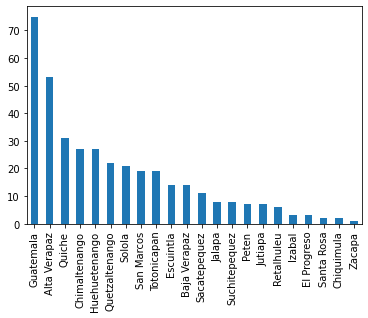

<Figure size 1440x360 with 0 Axes>


mun_reg


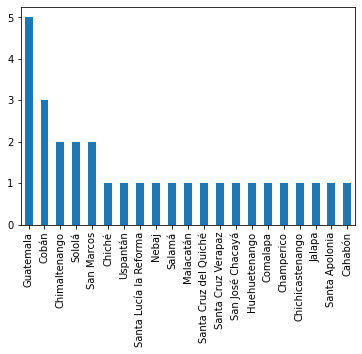

<Figure size 1440x360 with 0 Axes>


mon_reg


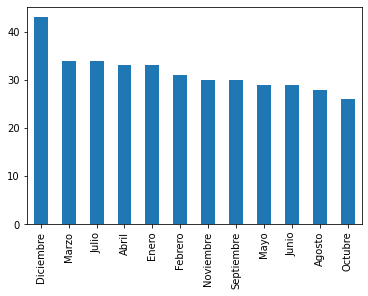

<Figure size 1440x360 with 0 Axes>


year_reg


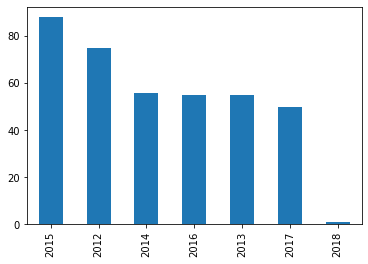

<Figure size 1440x360 with 0 Axes>


dep_occu


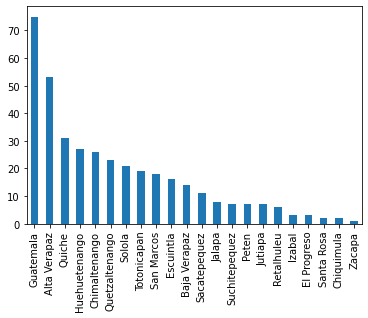

<Figure size 1440x360 with 0 Axes>


mun_occu


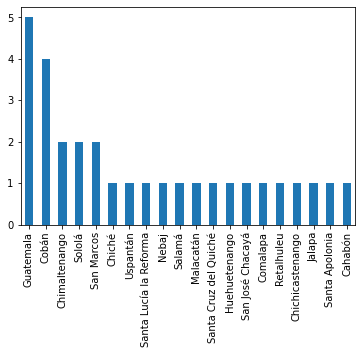

<Figure size 1440x360 with 0 Axes>


area_geog


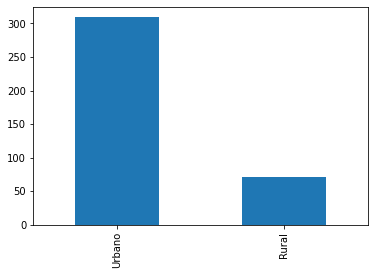

<Figure size 1440x360 with 0 Axes>


sex_death


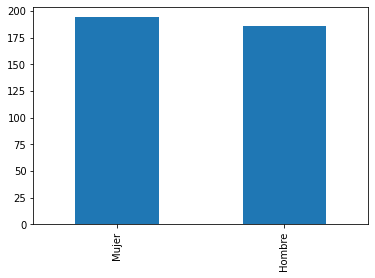

<Figure size 1440x360 with 0 Axes>


day_occu


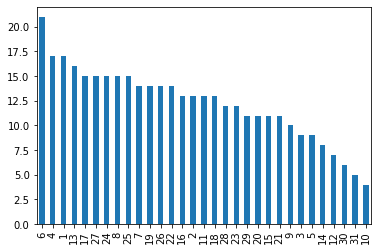

<Figure size 1440x360 with 0 Axes>


month_occu


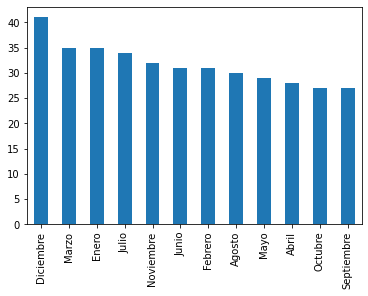

<Figure size 1440x360 with 0 Axes>


year_occu


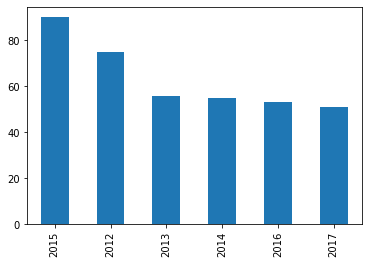

<Figure size 1440x360 with 0 Axes>


part_type


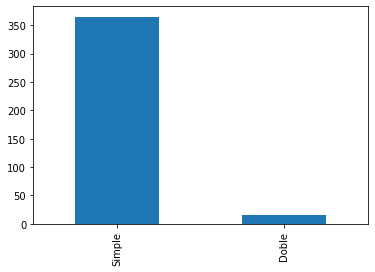

<Figure size 1440x360 with 0 Axes>


birth_class


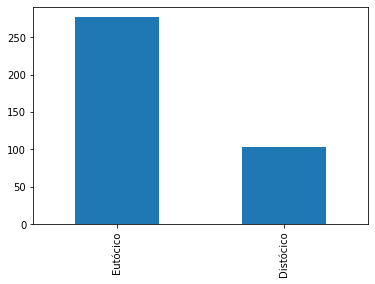

<Figure size 1440x360 with 0 Axes>


via_part


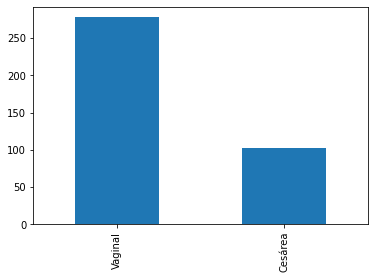

<Figure size 1440x360 with 0 Axes>


mom_country_res


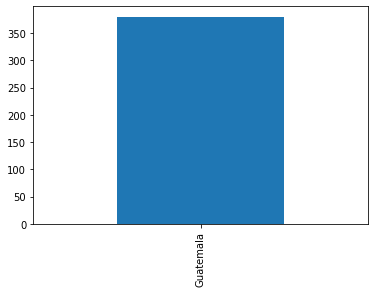

<Figure size 1440x360 with 0 Axes>


mom_dep_res


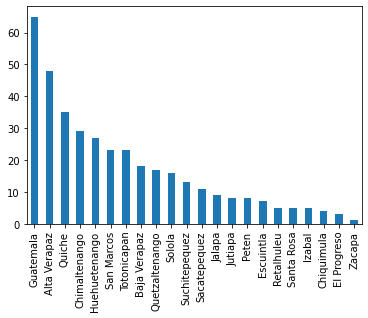

<Figure size 1440x360 with 0 Axes>


mom_mun_resi


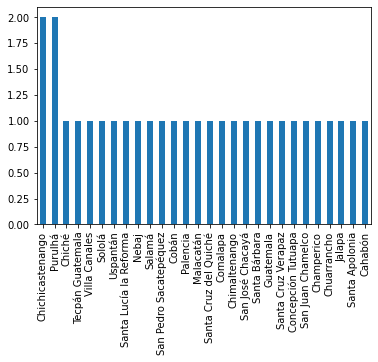

<Figure size 1440x360 with 0 Axes>


mom_group


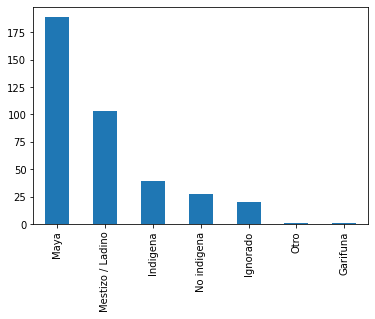

<Figure size 1440x360 with 0 Axes>


mom_civil_status


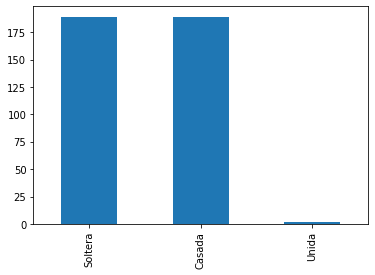

<Figure size 1440x360 with 0 Axes>


mom_nationality


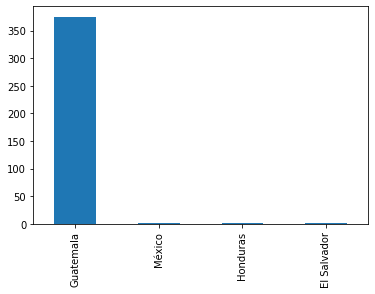

<Figure size 1440x360 with 0 Axes>


mom_scholarship


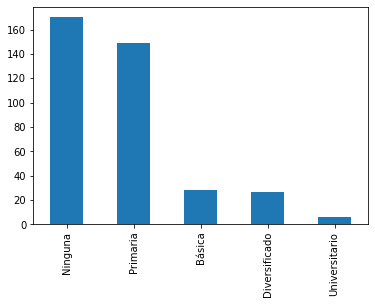

<Figure size 1440x360 with 0 Axes>


mom_occupation


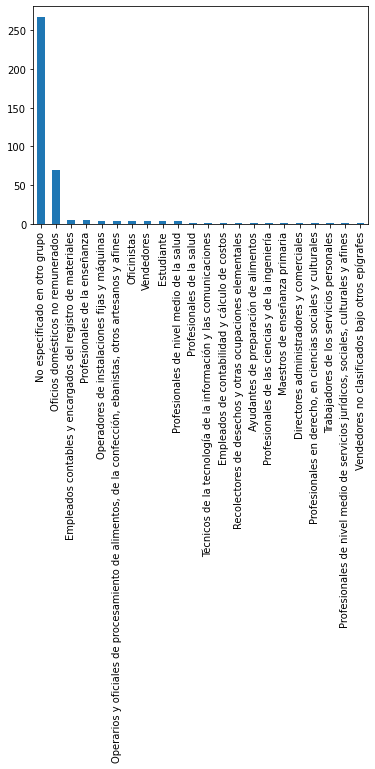

<Figure size 1440x360 with 0 Axes>


cause_death


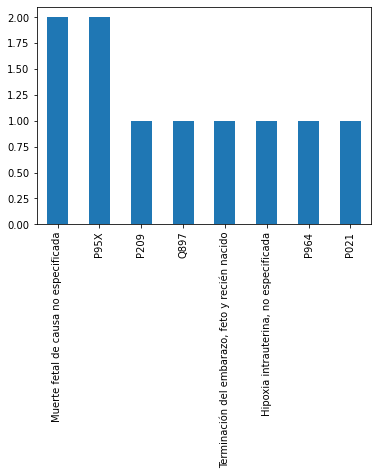

<Figure size 1440x360 with 0 Axes>


assistance_received


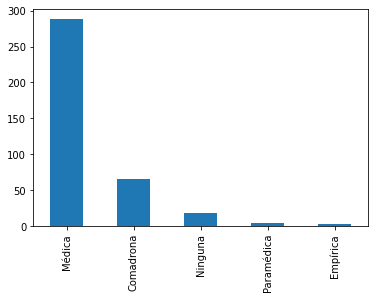

<Figure size 1440x360 with 0 Axes>


site_occu


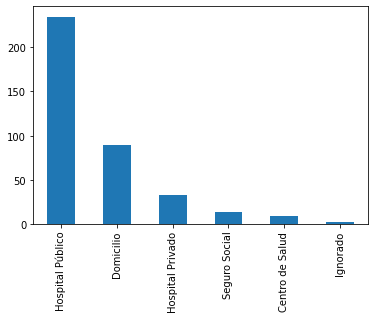

<Figure size 1440x360 with 0 Axes>

In [28]:
for var in qual_vars:
    
    if (var == "mun_occu" or var =="mun_reg" or var == 'mom_mun_resi'):
        data.sort_values(by=var, ascending=False)
        data[var].head(30).value_counts().plot(kind='bar')
    elif (var == 'cause_death'):
        data.sort_values(by=var, ascending=False)
        data[var].head(10).value_counts().plot(kind='bar')
    else:
        data[var].value_counts().plot(kind='bar')
    plt.figure(figsize=(20,5))
    print('\n'+ var)
    plt.show()

In [9]:
# frequency table of place of residence and fetal deaths
pd.crosstab(index=data['mom_dep_res'],
            columns=data['total_dead_children'], margins=True)

total_dead_children,1.0,2.0,3.0,4.0,5.0,6.0,7.0,All
mom_dep_res,,,,,,,,
Alta Verapaz,52,11,3,0,1,2,0,69
Baja Verapaz,8,2,1,1,0,0,0,12
Chimaltenango,16,8,1,0,0,0,0,25
Chiquimula,2,2,1,0,0,0,0,5
El Progreso,4,0,0,0,0,0,0,4
Escuintla,5,1,1,0,0,0,0,7
Guatemala,56,4,2,3,0,1,0,66
Huehuetenango,13,0,0,1,0,1,0,15
Izabal,1,0,1,0,0,0,0,2


<AxesSubplot:xlabel='mom_dep_res'>

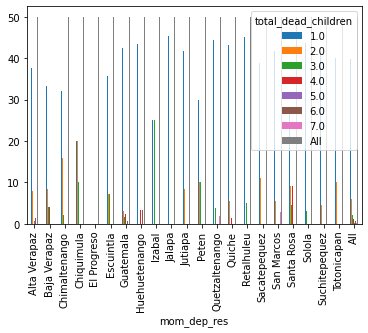

In [10]:
# Graph of place of residence and fetal deaths
pd.crosstab(index=data['mom_dep_res'],
            columns=data['total_dead_children'], margins=True).apply(lambda r: r/r.sum() *100, axis=1).plot(kind='bar')

In [11]:
# frequency table of place of birth and fetal deaths
pd.crosstab(index=data['site_occu'],
            columns=data['total_dead_children'], margins=True)

total_dead_children,1.0,2.0,3.0,4.0,5.0,6.0,7.0,All
site_occu,,,,,,,,
Centro de Salud,6,2,1,0,0,1,0,10
Domicilio,78,19,5,2,0,2,2,108
Hospital Privado,18,1,0,0,0,0,0,19
Hospital Público,159,19,7,5,1,2,0,193
Ignorado,23,3,1,0,0,0,0,27
Seguro Social,18,2,2,1,0,0,0,23
All,302,46,16,8,1,5,2,380


<AxesSubplot:xlabel='site_occu'>

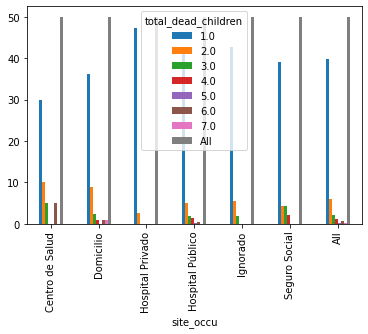

In [12]:
# Graph of place of birth and fetal deaths
pd.crosstab(index=data['site_occu'],
            columns=data['total_dead_children'], margins=True).apply(lambda r: r/r.sum() *100, axis=1).plot(kind='bar')

In [13]:
# frequency table of type of birth and fetal deaths
pd.crosstab(index=data['part_type'],
            columns=data['total_dead_children'], margins=True)

total_dead_children,1.0,2.0,3.0,4.0,5.0,6.0,7.0,All
part_type,,,,,,,,
Doble,6,0,4,0,0,0,0,10
Simple,295,46,12,8,1,5,2,369
Triple,1,0,0,0,0,0,0,1
All,302,46,16,8,1,5,2,380


<AxesSubplot:xlabel='part_type'>

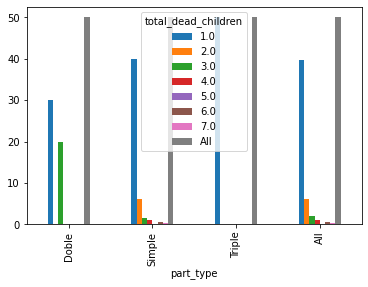

In [14]:
# Graph of type of birth and fetal deaths
pd.crosstab(index=data['part_type'],
            columns=data['total_dead_children'], margins=True).apply(lambda r: r/r.sum() *100, axis=1).plot(kind='bar')

In [15]:
# frequency table of mother's marital status and fetal deaths
pd.crosstab(index=data['mom_civil_status'],
            columns=data['total_dead_children'], margins=True)

total_dead_children,1.0,2.0,3.0,4.0,5.0,6.0,7.0,All
mom_civil_status,,,,,,,,
Casada,152,29,11,6,1,4,1,204
Ignorado,1,0,0,0,0,0,0,1
Soltera,148,17,5,2,0,1,1,174
Unido,1,0,0,0,0,0,0,1
All,302,46,16,8,1,5,2,380


<AxesSubplot:xlabel='mom_civil_status'>

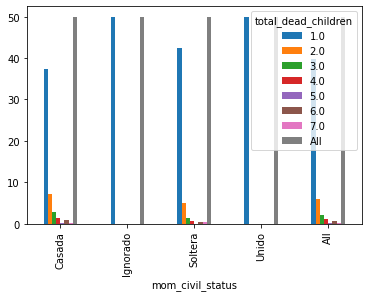

In [16]:
# Graph of mother's marital status and fetal deaths
pd.crosstab(index=data['mom_civil_status'],
            columns=data['total_dead_children'], margins=True).apply(lambda r: r/r.sum() *100, axis=1).plot(kind='bar')

In [17]:
# frequency table of gestation weeks and fetal deaths
pd.crosstab(index=data['weeks_ges'],
            columns=data['total_dead_children'], margins=True)

total_dead_children,1.0,2.0,3.0,4.0,5.0,6.0,7.0,All
weeks_ges,,,,,,,,
-1.0,33,6,3,1,0,1,2,46
18.0,2,0,0,0,0,0,0,2
19.0,1,0,0,0,0,0,0,1
20.0,1,1,1,0,0,0,0,3
22.0,2,0,0,0,0,1,0,3
23.0,6,0,0,0,0,0,0,6
24.0,9,0,0,0,0,0,0,9
25.0,8,3,0,0,0,0,0,11
26.0,6,2,2,1,0,0,0,11


<AxesSubplot:xlabel='weeks_ges'>

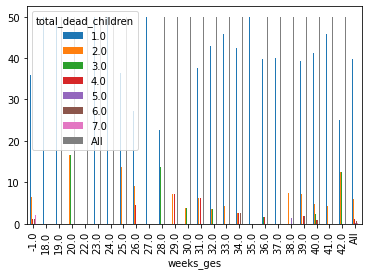

In [18]:
# Graph  of gestation weeks and fetal deaths
pd.crosstab(index=data['weeks_ges'],
            columns=data['total_dead_children'], margins=True).apply(lambda r: r/r.sum() *100, axis=1).plot(kind='bar')

In [19]:
# frequency table of place of birth and total born
pd.crosstab(index=data['site_occu'],
            columns=data['total_children'], margins=True)

total_children,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0,14.0,All
site_occu,,,,,,,,,,,,,,,
Centro de Salud,1,1,1,4,1,1,0,0,0,0,0,0,1,0,10
Domicilio,2,23,21,15,7,14,6,8,5,4,2,1,0,0,108
Hospital Privado,1,10,2,3,1,1,0,1,0,0,0,0,0,0,19
Hospital Público,11,50,47,32,17,9,10,8,4,3,0,1,0,1,193
Ignorado,0,16,6,3,1,1,0,0,0,0,0,0,0,0,27
Seguro Social,1,9,7,3,2,0,1,0,0,0,0,0,0,0,23
All,16,109,84,60,29,26,17,17,9,7,2,2,1,1,380


### Clean of quant vars

In [20]:
quan_df = data[quan_vars]
quan_df[quan_vars] = quan_df[quan_vars].astype(float)
quan_df[quan_vars] = quan_df[quan_vars].astype(int)


graph_labels = [quan_vars[0], quan_vars[1]]

count    380.000000
mean      29.565789
std        6.729872
min       17.000000
25%       24.000000
50%       29.000000
75%       35.000000
max       45.000000
Name: mother_age, dtype: float64

mother_age: Kurtosis: -0.7898603697488484 Skewness: 0.23592430626699426 



count    380.000000
mean       3.963158
std        2.356983
min        1.000000
25%        2.000000
50%        3.000000
75%        5.000000
max       14.000000
Name: total_children, dtype: float64

total_children: Kurtosis: 1.6735056917043414 Skewness: 1.3528359491806103 



count    380.000000
mean       1.376316
std        0.948804
min        1.000000
25%        1.000000
50%        1.000000
75%        1.000000
max        7.000000
Name: total_dead_children, dtype: float64

total_dead_children: Kurtosis: 13.195537647958268 Skewness: 3.4197043483708853 



count    364.000000
mean       2.700549
std        2.051916
min        1.000000
25%        1.000000
50%        2.000000
75%        4.000000
max       11.000000
Name: total_living_children, dtype: float64

total_living_children: Kurtosis: 1.6671595657210165 Skewness: 1.441293770719586 



count    334.000000
mean      34.535928
std        5.648107
min       18.000000
25%       31.000000
50%       36.000000
75%       39.000000
max       42.000000
Name: weeks_ges, dtype: float64

weeks_ges: Kurtosis: -0.23328579959416818 Skewness: -0.8768439581107711 



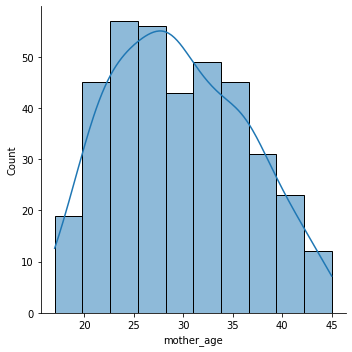

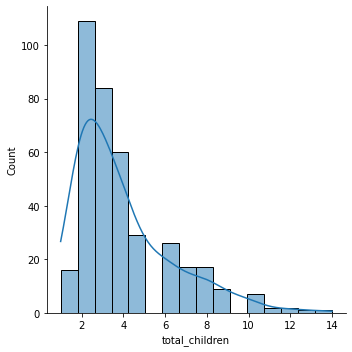

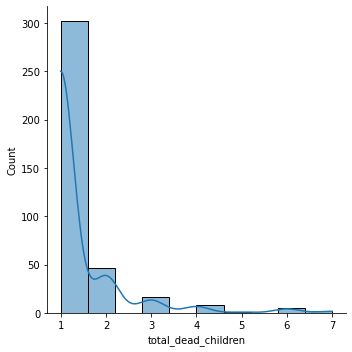

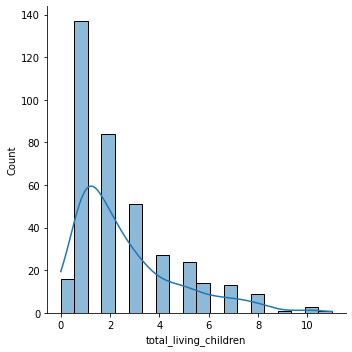

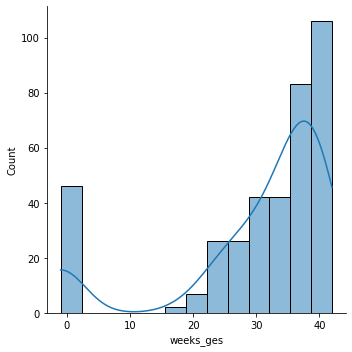

In [21]:
for var in quan_vars:
  serie = quan_df[quan_df[var] > 0][var]
  display(serie.describe())
  sns.displot(quan_df[var], kde=True)
  print('\033[1m' + var + '\033[0m' + ': Kurtosis:', stats.kurtosis(serie), 'Skewness:', stats.skew(serie), '\n')

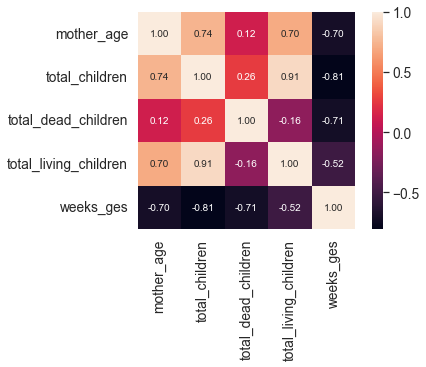

In [22]:
k = 10 #number of variables for heatmap
corrmat = quan_df.corr()
cm = np.corrcoef(corrmat.values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=quan_vars, xticklabels=quan_vars)
plt.show()

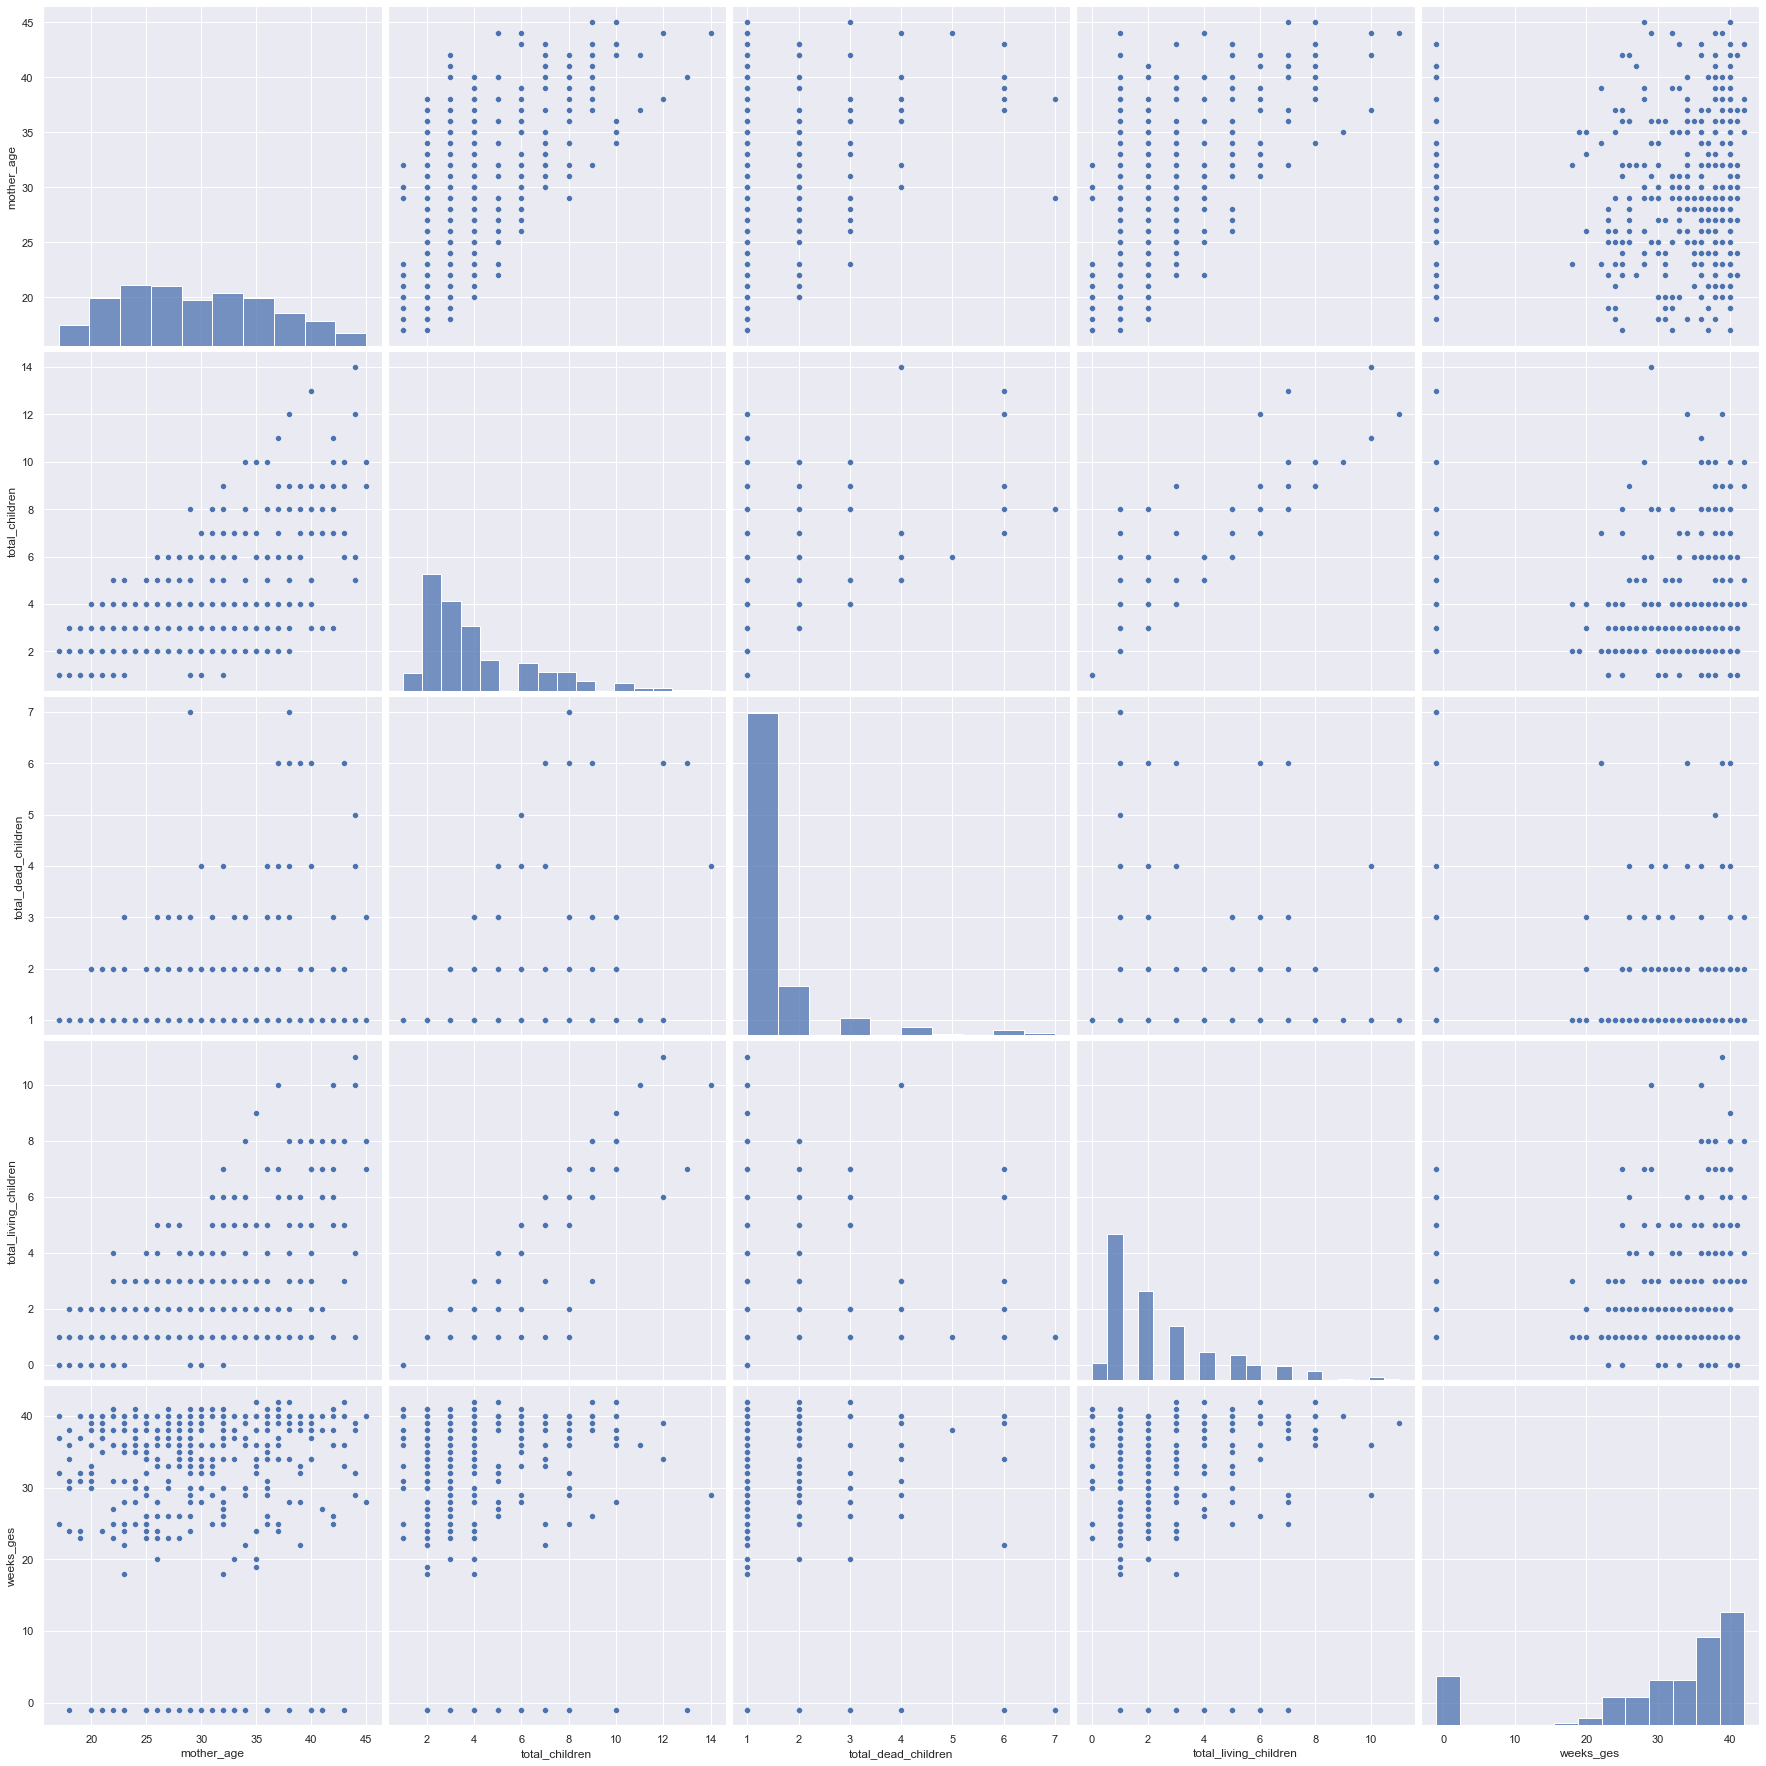

In [23]:
sns.set()
sns.pairplot(quan_df, height= 5)
plt.show()

## NACIMIENTOS

In [30]:
nc_var_names = ['dep_reg', 'mun_reg', 'mon_reg', 'year_reg', 'inscirption', 'dep_occu','mun_occu', 'area_geog', 'pounds_weight', 'ounces_weight',
'day_occu', 'month_occu','year_occu', 'genre', 'part_type','via_part', 'dad_age', 'dad_contry', 'dep_dad', 'mun_dad',
'dad_group', 'dad_civil', 'birth_country_dad', 'birt_dep_dad', 'birth_mun_dad', 'dad_nan', 'dad_scholar', 'dad_occup', 'mother_age', 
'mom_country_res', 'mom_dep_res', 'mom_mun_resi', 'mom_group', 'mom_civil_status', 'birth_country_mom', 'birth_dep_mom', 'birth_mun_mom',
'mom_nationality', 'mom_scholarship', 'mom_occupation', 'assistance_received', 'site_occu', 'total_children', 'total_dead_children', 
'total_living_children']

filter = ['dep_reg', 'mun_reg', 'mon_reg', 'year_reg', 'dep_occu', 'mun_occu', 'day_occu', 'month_occu', 'part_type', 'via_part',
'mother_age', 'mom_country_res', 'mom_dep_res', 'mom_mun_resi', 'mom_group', 'mom_civil_status', 'mom_scholarship', 'mom_occupation', 
'assistance_received', 'site_occu', 'total_children', 'total_dead_children', 'total_living_children']

nc_quan_vars = ['mother_age', 'total_children', 'total_dead_children', 'total_living_children']
nc_qual_vars = []
for var in filter: 
  if var not in nc_quan_vars: nc_qual_vars.append(var)

In [31]:
def nc_filter_df(data_frame, to_remove, is_quali=True):
  df = data_frame.copy()
  all_vars = nc_var_names[:]
  remove_vars = to_remove[:]

  for var in remove_vars: all_vars.remove(var)
  df.columns = all_vars
  for var in remove_vars:
    df[var] = np.full(len(df.index), np.nan if is_quali else 0)
  return df.reindex(sorted(df.columns), axis=1).copy()

def drop_df_colums(data_frame, to_remove):
  df = data_frame.copy()
  all_vars = nc_var_names[:]
  remove_vars = to_remove[:]

  for var in remove_vars: all_vars.remove(var)
  for var in all_vars:
    df = df.drop(var, axis=1)
  return df.copy()

In [39]:
nc_2009 = pd.read_spss('./data/nc_2009.sav')
nc_2010 = pd.read_spss('./data/nc_2010.sav')
nc_2011 = pd.read_spss('./data/nc_2011.sav')
nc_2012 = pd.read_spss('./data/nc_2012.sav')
nc_2013 = pd.read_spss('./data/nc_2013.sav')
nc_2014 = pd.read_spss('./data/nc_2014.sav')
nc_2015 = pd.read_spss('./data/nc_2015.sav')
nc_2016 = pd.read_spss('./data/nc_2016.sav')
nc_2017 = pd.read_spss('./data/nc_2017.sav')
nc_2018 = pd.read_spss('./data/nc_2018.sav')
nc_2019 = pd.read_spss('./data/nc_2019.sav')
nc_2020 = pd.read_spss('./data/nc_2020.sav')

nc_2009 = nc_filter_df(nc_2009, ['inscirption', 'via_part', 'dad_contry', 'birth_country_dad', 'dad_scholar', 'mom_country_res', 'birth_country_mom', 'mom_scholarship'])
nc_2009['year_reg'] = np.full(len(nc_2009.index), '2009')
nc_2010 = nc_filter_df(nc_2010, ['inscirption', 'via_part', 'dad_contry', 'birth_country_dad', 'mom_country_res', 'birth_country_mom'])
nc_2010['year_reg'] = np.full(len(nc_2010.index), '2010')
nc_2011 = nc_filter_df(nc_2011, ['inscirption', 'via_part', 'dad_contry', 'birth_country_dad', 'mom_country_res', 'birth_country_mom'])
nc_2011['year_reg'] = np.full(len(nc_2011.index), '2011')
nc_2012 = nc_filter_df(nc_2012, ['inscirption', 'area_geog', 'year_occu', 'via_part'])
nc_2012['year_reg'] = np.full(len(nc_2012.index), '2012')
nc_2013 = nc_filter_df(nc_2013, ['inscirption', 'area_geog', 'year_occu', 'via_part'])
nc_2013['year_reg'] = np.full(len(nc_2013.index), '2013')
nc_2014 = nc_filter_df(nc_2014, ['inscirption', 'area_geog',  'year_occu', 'via_part', 'dad_nan', 'mom_nationality'])
nc_2014['year_reg'] = np.full(len(nc_2014.index), '2014')
nc_2015 = nc_filter_df(nc_2015, ['area_geog', 'dad_nan', 'mom_nationality'])
nc_2015['year_reg'] = np.full(len(nc_2015.index), '2015')
nc_2016 = nc_filter_df(nc_2016, ['area_geog', 'dad_nan', 'mom_nationality'])
nc_2016['year_reg'] = np.full(len(nc_2016.index), '2016')
nc_2017 = nc_filter_df(nc_2017, ['area_geog', 'dad_nan', 'mom_nationality'])
nc_2017['year_reg'] = np.full(len(nc_2017.index), '2017')
nc_2018 = nc_filter_df(nc_2018, ['area_geog', 'dad_nan', 'mom_nationality'])
nc_2018['year_reg'] = np.full(len(nc_2018.index), '2018')
nc_2019 = nc_filter_df(nc_2019, ['area_geog', 'dad_nan', 'mom_nationality'])
nc_2019['year_reg'] = np.full(len(nc_2019.index), '2019')
nc_2020 = nc_filter_df(nc_2020, ['area_geog', 'dad_nan', 'mom_nationality'])
nc_2020['year_reg'] = np.full(len(nc_2020.index), '2020')

nc_2009 = drop_df_colums(nc_2009, filter)
nc_2010 = drop_df_colums(nc_2010, filter)
nc_2011 = drop_df_colums(nc_2011, filter)
nc_2012 = drop_df_colums(nc_2012, filter)
nc_2013 = drop_df_colums(nc_2013, filter)
nc_2014 = drop_df_colums(nc_2014, filter)
nc_2015 = drop_df_colums(nc_2015, filter)
nc_2016 = drop_df_colums(nc_2016, filter)
nc_2017 = drop_df_colums(nc_2017, filter)
nc_2018 = drop_df_colums(nc_2018, filter)
nc_2019 = drop_df_colums(nc_2019, filter)
nc_2020 = drop_df_colums(nc_2020, filter)

nc_data = pd.concat([nc_2009, nc_2010, nc_2011, nc_2012, nc_2013, nc_2014, nc_2015, nc_2016, nc_2017, nc_2018, nc_2019, nc_2020])

In [40]:
quan_nc = nc_data[nc_quan_vars].replace('Ignorado', -1).fillna(-1)
nc_data = pd.concat([quan_nc, nc_data[nc_qual_vars]], axis=1)
nc_data = nc_data.drop(nc_data[nc_data[quan_vars[0]] < 0].index)
nc_data = nc_data.drop(nc_data[nc_data[quan_vars[1]] < 0].index)

In [41]:
temp_nc = nc_data.copy()
response = ['mom_scholarship', 'mom_dep_res', 'mom_occupation', 'mother_age', 'total_children', 'total_dead_children', 'total_living_children']
to_remove = ['Ignorado', 'nan', '99.0']

# adding strange
for element in list(temp_nc[response[2]].value_counts().index):
  try:
    float(element)
    to_remove.append(element)
  except:
    pass

temp_nc = temp_nc[~temp_nc[response[0]].isin(to_remove)]
temp_nc = temp_nc.replace(['Ninguno', 'Básico', 'Oficios domésticos no remunerado'], ['Ninguna', 'Básica','Oficios domésticos no remunerados'])
temp_nc = temp_nc[~temp_nc[response[1]].isin(to_remove)]
temp_nc = temp_nc[~temp_nc[response[2]].isin(to_remove)]

In [50]:
temp_nc = temp_nc.replace(['Médica', 'Médico', 'Medico', 'Medica'], 'Medico')
temp_nc = temp_nc.replace(['Paramédico', 'Paramédica'], 'Paramedico')

In [51]:
nc_data = temp_nc.sample(n=380, random_state=1)

In [53]:
nc_quan_df = nc_data[nc_quan_vars]

In [ ]:
for var in nc_quan_vars:
  serie = nc_quan_df[nc_quan_df[var] > 0][var]
  display(serie.describe())
  sns.displot(nc_quan_df[var], kde=True)
  print('\033[1m' + var + '\033[0m' + ': Kurtosis:', stats.kurtosis(serie), 'Skewness:', stats.skew(serie), '\n')

In [ ]:
k = 10 #number of variables for heatmap
corrmat = nc_quan_df.corr()
cm = np.corrcoef(corrmat.values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=nc_quan_vars, xticklabels=nc_quan_vars)
plt.show()

In [ ]:
sns.set()
sns.pairplot(nc_quan_df, height= 5)
plt.show()


dep_reg


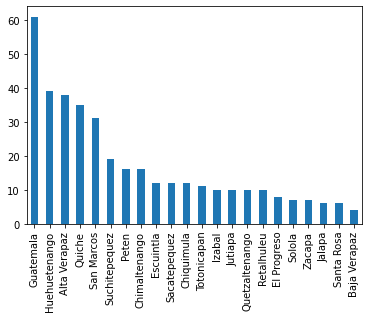

<Figure size 1440x360 with 0 Axes>


mun_reg


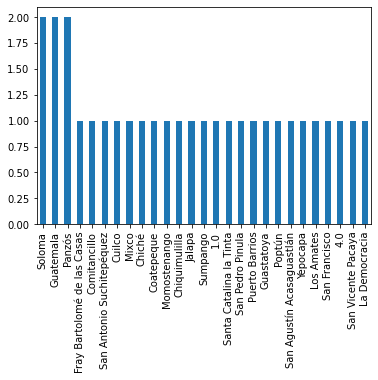

<Figure size 1440x360 with 0 Axes>


mon_reg


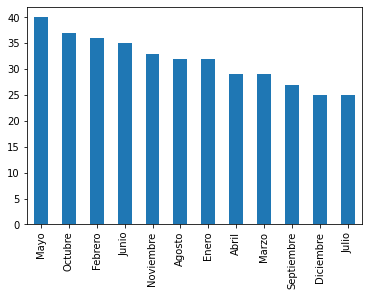

<Figure size 1440x360 with 0 Axes>


year_reg


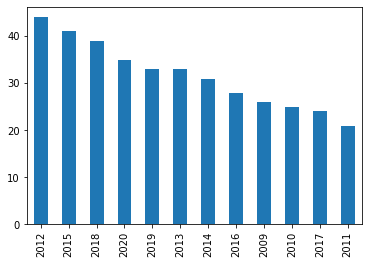

<Figure size 1440x360 with 0 Axes>


dep_occu


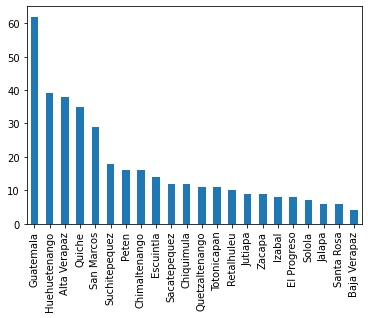

<Figure size 1440x360 with 0 Axes>


mun_occu


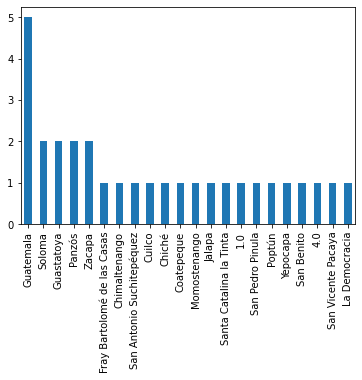

<Figure size 1440x360 with 0 Axes>


day_occu


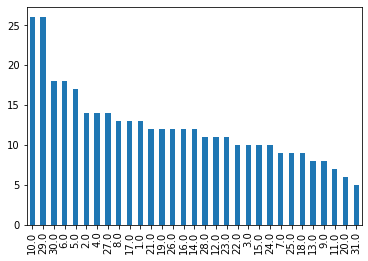

<Figure size 1440x360 with 0 Axes>


month_occu


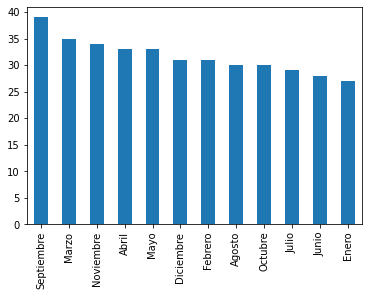

<Figure size 1440x360 with 0 Axes>


part_type


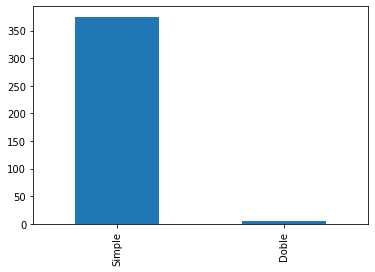

<Figure size 1440x360 with 0 Axes>


via_part


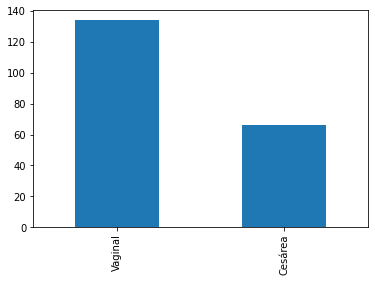

<Figure size 1440x360 with 0 Axes>


mom_country_res


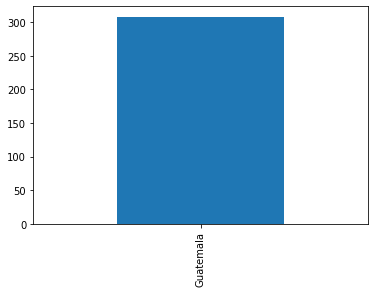

<Figure size 1440x360 with 0 Axes>


mom_dep_res


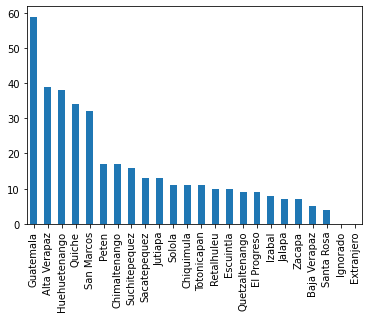

<Figure size 1440x360 with 0 Axes>


mom_mun_resi


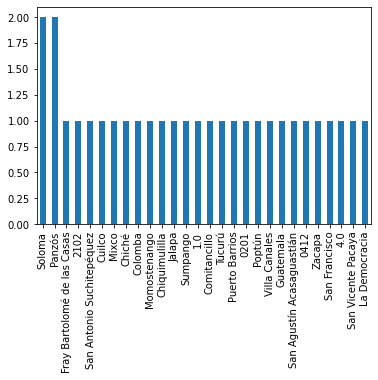

<Figure size 1440x360 with 0 Axes>


mom_group


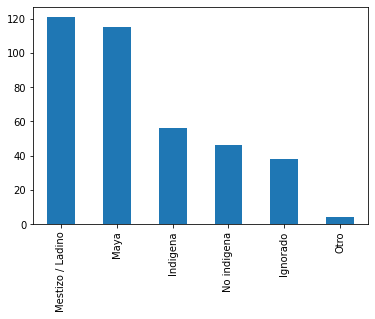

<Figure size 1440x360 with 0 Axes>


mom_civil_status


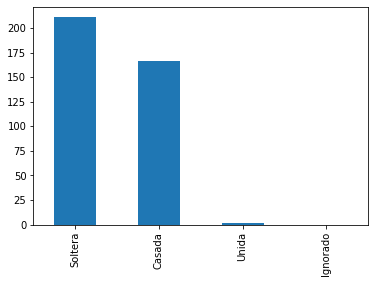

<Figure size 1440x360 with 0 Axes>


mom_scholarship


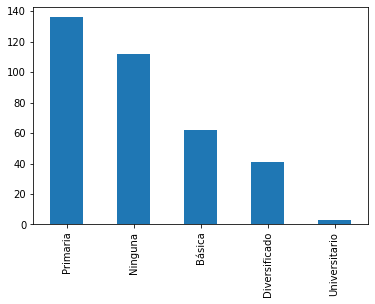

<Figure size 1440x360 with 0 Axes>


mom_occupation


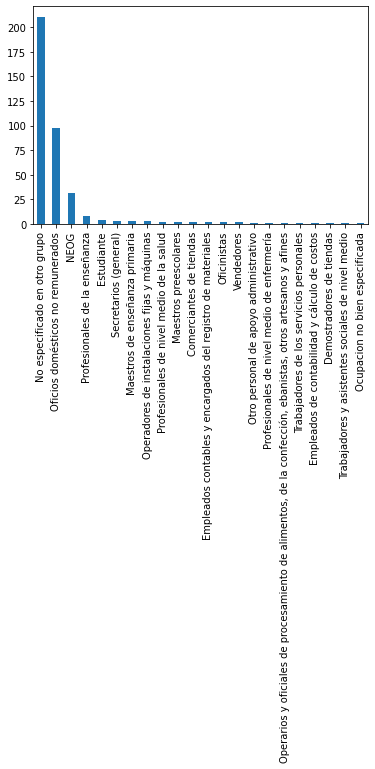

<Figure size 1440x360 with 0 Axes>


assistance_received


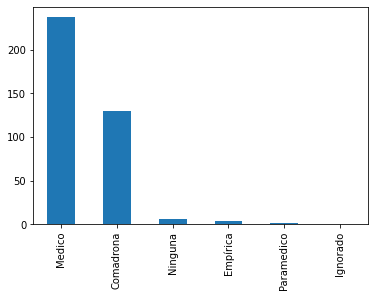

<Figure size 1440x360 with 0 Axes>


site_occu


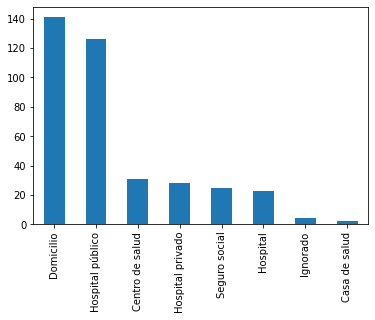

<Figure size 1440x360 with 0 Axes>

In [54]:
for var in nc_qual_vars:
    if (var == "mun_reg" or var == 'mun_occu' or var == 'mom_mun_resi'):
        nc_data[var].head(30).value_counts().plot(kind='bar')
    else:
        nc_data[var].value_counts().plot(kind='bar')

    plt.figure(figsize=(20,5))
    print('\n'+ var)
    plt.show()

In [35]:
# frequency table of mom departament residence and births
pd.crosstab(index=data['mom_dep_res'],
            columns=data['total_living_children'], margins=True)

total_living_children,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,All
mom_dep_res,,,,,,,,,,,,,
Alta Verapaz,2,23,14,17,4,1,4,2,1,1,0,0,69
Baja Verapaz,1,1,4,1,1,2,0,0,2,0,0,0,12
Chimaltenango,2,4,9,0,2,4,1,1,2,0,0,0,25
Chiquimula,0,0,1,1,2,1,0,0,0,0,0,0,5
El Progreso,0,2,0,2,0,0,0,0,0,0,0,0,4
Escuintla,0,5,0,0,0,1,0,1,0,0,0,0,7
Guatemala,5,31,17,4,3,2,1,2,0,0,1,0,66
Huehuetenango,1,5,3,3,0,1,0,2,0,0,0,0,15
Izabal,0,1,1,0,0,0,0,0,0,0,0,0,2


<AxesSubplot:xlabel='mom_dep_res'>

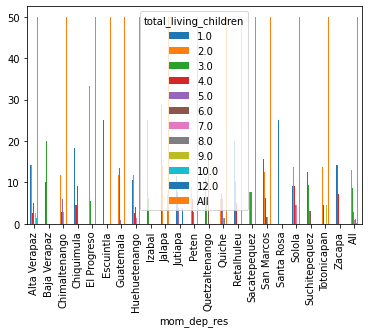

In [55]:
# Graph of place of mom departament residence and births
pd.crosstab(index=nc_data['mom_dep_res'],
            columns=nc_data['total_living_children'], dropna=True, margins=True).apply(lambda r: r/r.sum() *100, axis=1).plot(kind='bar')

In [56]:
# frequency table of mom scholarship and births
pd.crosstab(index=nc_data['mom_scholarship'],
            columns=nc_data['total_living_children'], margins=True)

total_living_children,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,12.0,All
mom_scholarship,,,,,,,,,,,,
Básica,26,22,11,3,0,0,0,0,0,0,0,62
Diversificado,14,18,8,1,0,0,0,0,0,0,0,41
Ninguna,30,15,16,12,14,9,5,5,3,2,1,112
Primaria,45,35,30,13,4,6,1,2,0,0,0,136
Universitario,1,2,0,0,0,0,0,0,0,0,0,3
All,116,92,65,29,18,15,6,7,3,2,1,354


<AxesSubplot:xlabel='mom_dep_res'>

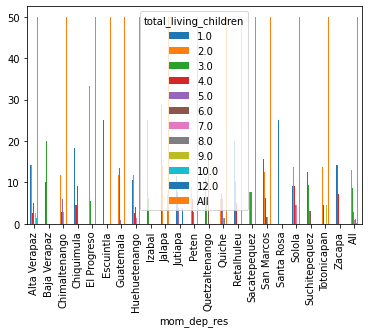

In [57]:
# Graph of place of mom scholarship residence and births
pd.crosstab(index=nc_data['mom_dep_res'],
            columns=nc_data['total_living_children'], dropna=True, margins=True).apply(lambda r: r/r.sum() *100, axis=1).plot(kind='bar')

In [58]:
# frequency table of mom occupation and births
pd.crosstab(index=nc_data['mom_scholarship'],
            columns=nc_data['total_living_children'], margins=True)

total_living_children,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,12.0,All
mom_scholarship,,,,,,,,,,,,
Básica,26,22,11,3,0,0,0,0,0,0,0,62
Diversificado,14,18,8,1,0,0,0,0,0,0,0,41
Ninguna,30,15,16,12,14,9,5,5,3,2,1,112
Primaria,45,35,30,13,4,6,1,2,0,0,0,136
Universitario,1,2,0,0,0,0,0,0,0,0,0,3
All,116,92,65,29,18,15,6,7,3,2,1,354


<AxesSubplot:xlabel='mom_scholarship'>

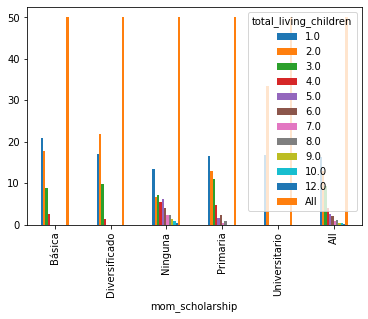

In [59]:
# Graph of place of mom occupation residence and births
pd.crosstab(index=nc_data['mom_scholarship'],
            columns=nc_data['total_living_children'], dropna=True, margins=True).apply(lambda r: r/r.sum() *100, axis=1).plot(kind='bar')

In [60]:
# frequency table of site of occurrence and births
pd.crosstab(index=nc_data['site_occu'],
            columns=nc_data['total_living_children'], margins=True)

total_living_children,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,12.0,All
site_occu,,,,,,,,,,,,
Casa de salud,0,2,0,0,0,0,0,0,0,0,0,2
Centro de salud,14,9,6,1,0,0,0,0,1,0,0,31
Domicilio,27,28,24,22,12,11,4,8,2,2,1,141
Hospital,12,5,2,1,3,0,0,0,0,0,0,23
Hospital privado,9,10,8,1,0,0,0,0,0,0,0,28
Hospital público,55,35,16,7,6,6,1,0,0,0,0,126
Ignorado,2,1,1,0,0,0,0,0,0,0,0,4
Seguro social,7,8,9,0,0,0,1,0,0,0,0,25
All,126,98,66,32,21,17,6,8,3,2,1,380


<AxesSubplot:xlabel='site_occu'>

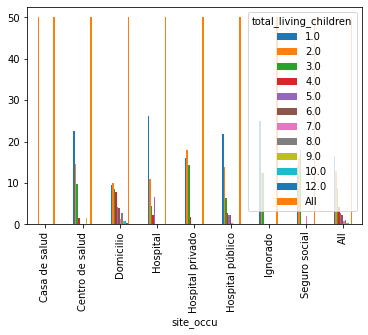

In [61]:
# Graph of place of site of occurrence e and births
pd.crosstab(index=nc_data['site_occu'],
            columns=nc_data['total_living_children'], dropna=True, margins=True).apply(lambda r: r/r.sum() *100, axis=1).plot(kind='bar')

1. Comience  describiendo  cuantas  variables  y  observaciones  tiene  disponibles,  el tipo de cada una de las variables. 

2. Haga un resumen de las variables numéricas e investigue si siguen una distribución normal y tablas de frecuencia para las variables categóricas, escriba lo que vaya encontrando. 

3. Cruce  las  variables  que  considere  que  son  las  más  importantes  para  hallar  los elementos  clave  que  lo  pueden  llevar  a  comprender  lo  que  está  causando  el problema encontrado.

4. Haga gráficos exploratorios que le de ideas del estado de los datos. 

5. Haga un agrupamiento (clustering) e interprete los resultados. 

## Clustering

In [43]:
random.seed(123)
X_scale=sklearn.preprocessing.scale(quan_df)

pyclustertend.hopkins(X_scale, len(X_scale))

0.11597254882917907

El valor de hopkins es de 0.11, por lo que vale la pena hacer el agrupamiento al tener datos distribuidos de manera uniforme.

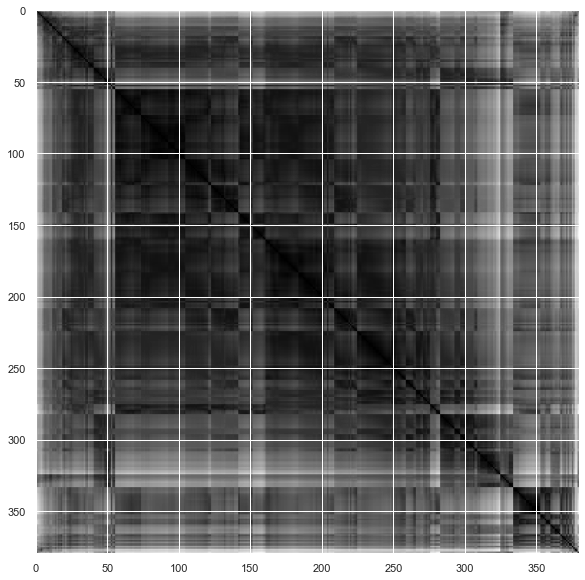

In [44]:
pyclustertend.vat(X_scale)

Se realiza la gráfica de codo para encontrar la cantidad óptima de clusters

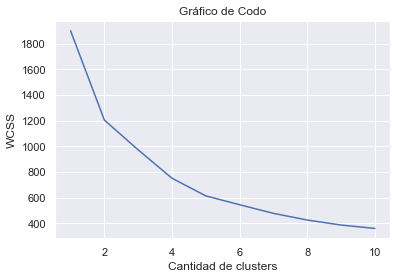

In [45]:
numeroClusters = range(1,11)

wcss = []
# Obtenemos 10 posibles clusters
for i in numeroClusters:
    # Se calcula la kmean con esa cantidad de clusters
    kmeans = cluster.KMeans(n_clusters=i)
    kmeans.fit(X_scale)
    # Obtenemos la inercia
    wcss.append(kmeans.inertia_)

# Graficando
plt.plot(numeroClusters, wcss)
plt.xlabel("Cantidad de clusters")
plt.ylabel("WCSS")
plt.title("Gráfico de Codo")
plt.show()

Se harán uso de 4 clusters

In [46]:
number_clusters = 4
colors = ['mediumslateblue', 'skyblue', 'pink', 'cornflowerblue']

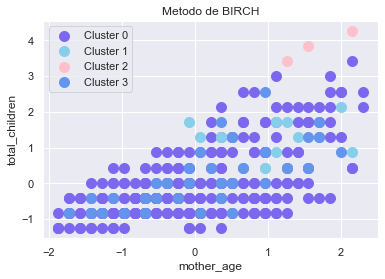

In [47]:
# Inicializar el modelo
birch_model = Birch(threshold=1.5, n_clusters=number_clusters)
birch_model.fit(X_scale)

# Obtenemos los puntos y los clusters
birch_result = birch_model.predict(X_scale)

for i in range(number_clusters):
    # Graficar los clusters
    plt.scatter(X_scale[birch_result == i, 0], X_scale[birch_result == i, 1], s = 100, c = colors[i], label = "Cluster %d" %i)

plt.title("Metodo de BIRCH")
plt.xlabel(graph_labels[0])
plt.ylabel(graph_labels[1])
plt.legend()
plt.show()

## Silueta

For n_clusters = 4 The average silhouette_score of BIRCH is: 0.38424955684996465


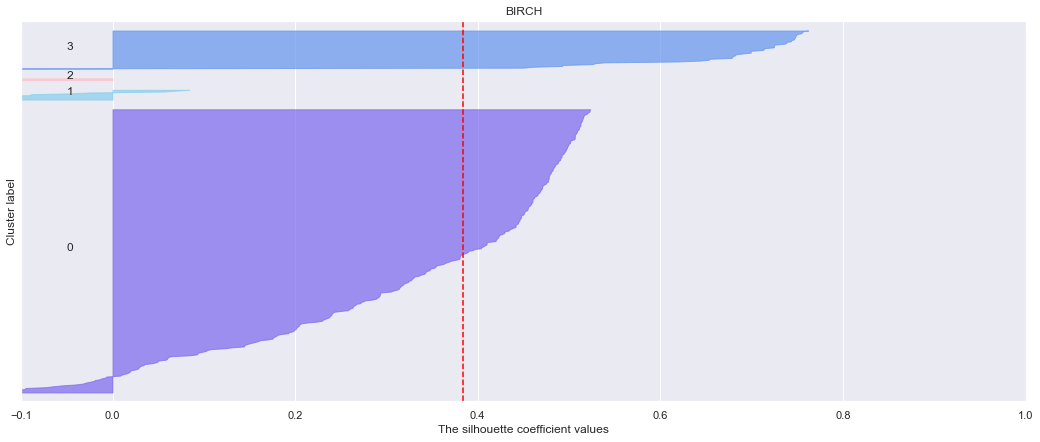

In [48]:
def make_silhouette(clusterer, n_clusters, label):
    fig, ax = plt.subplots(figsize=(1,1))
    fig.set_size_inches(18, 7)

    ax.set_xlim([-0.1, 1])
    ax.set_ylim([0, len(X_scale) + (n_clusters + 1) * 10])

    cluster_labels = clusterer.fit_predict(X_scale)

    silhouette_avg = silhouette_score(X_scale, cluster_labels)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score of",
        label,
        'is:',
        silhouette_avg,
    )

    sample_silhouette_values = silhouette_samples(quan_df, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = colors[i]
        ax.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        y_lower = y_upper + 10  # 10 for the 0 samples

    ax.set_title(label)
    ax.set_xlabel("The silhouette coefficient values")
    ax.set_ylabel("Cluster label")

    ax.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax.set_yticks([]) 
    ax.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

make_silhouette(birch_model, number_clusters, 'BIRCH')
plt.show()

## Matriz de confusion

In [49]:
stamps = ['dep_reg', 'assistance_received', 'site_occu', 'cause_death']

Cambiando las variables cualitativas a numeros

In [50]:
for stamp in stamps:
  aux = data.groupby(by=stamp)
  
  
  tag_group = list(aux.groups.keys())
  tag_group = [x.lower() for x in tag_group]
  tag_group = list(dict.fromkeys(tag_group))

  
  lower_case_col = data[[stamp]]
  lower_case_col[stamp] =  lower_case_col[stamp].str.lower()
  tags_list = lower_case_col.values.tolist()

  tags = []
  tag_to_number = {}
  number_to_taga = {}

  for i in range(len(tag_group)): 
    tag_to_number[tag_group[i]] = i
    number_to_taga[i] = tag_group[i]

  for i in range(len(tags_list)):
    tags.append(tag_to_number[tags_list[i][0]])

    # Se realiza el analisis de los grupos
  confusion_birch = confusion_matrix(birch_result, tags)[0:number_clusters]

  # Se observar como es que estan por categoria
  def get_category(confusion_array, label=''):
    print('_'*100)
    print('\nCONFUSION DE:', label, 'CON LA VARIABLE CUALITATIVA', stamp)
    keys = list(tag_to_number.keys())
    for i in range(number_clusters):
      print('\nCLUSTER #', i)
      result = list(confusion_array[i])
      index = result.index(max(result))
      '''
      for i in range(len(result)):
        print('%s con %d' %(keys[i], result[i]))
      '''

      print('Se asegura que es el grupo de: %s con %d' %(keys[index], result[index]))
    
    print('_'*100)

  get_category(confusion_birch, 'BIRCH')

____________________________________________________________________________________________________

CONFUSION DE: BIRCH CON LA VARIABLE CUALITATIVA dep_reg

CLUSTER # 0
Se asegura que es el grupo de: guatemala con 81

CLUSTER # 1
Se asegura que es el grupo de: guatemala con 3

CLUSTER # 2
Se asegura que es el grupo de: alta verapaz con 1

CLUSTER # 3
Se asegura que es el grupo de: alta verapaz con 9
____________________________________________________________________________________________________
____________________________________________________________________________________________________

CONFUSION DE: BIRCH CON LA VARIABLE CUALITATIVA assistance_received

CLUSTER # 0
Se asegura que es el grupo de: médica con 232

CLUSTER # 1
Se asegura que es el grupo de: médica con 8

CLUSTER # 2
Se asegura que es el grupo de: médica con 2

CLUSTER # 3
Se asegura que es el grupo de: comadrona con 22
__________________________________________________________________________________________

# ANALISIS PARTE 2

### Plot 2D

In [51]:
def showGraph(): 
    scaler.fit(X_test)
    X_test_scaled = scaler.transform(X_test)


    pca2 = PCA(n_components=2)
    X_test_scaled_reduced = pca2.fit_transform(X_test_scaled)

    svm_model = SVC(kernel=grid.best_params_['SupVM__kernel'], C=float(grid.best_params_['SupVM__C']), gamma=float(grid.best_params_['SupVM__gamma']))

    classify = svm_model.fit(X_test_scaled_reduced, y_test)

    def plot_contours(ax, clf, xx, yy, **params):
        Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
        print ('initial decision function shape; ', np.shape(Z))
        Z = Z.reshape(xx.shape)
        print ('after reshape: ', np.shape(Z))
        out = ax.contourf(xx, yy, Z, **params)
        return out

    def make_meshgrid(x, y, h=.1):
        x_min, x_max = x.min() - 1, x.max() + 1
        y_min, y_max = y.min() - 1, y.max() + 1
        xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                            np.arange(y_min, y_max, h))#,
                            #np.arange(z_min, z_max, h))
        return xx, yy

    X0, X1 = X_test_scaled_reduced[:, 0], X_test_scaled_reduced[:, 1]
    xx, yy = make_meshgrid(X0, X1)

    fig, ax = plt.subplots(figsize=(12,9))
    fig.patch.set_facecolor('white')
    cdict1={0:'lime',1:'deeppink'}

    Y_tar_list = y_test.tolist()
    yl1= [int(target1) for target1 in Y_tar_list]
    labels1=yl1
    
    labl1={0:'Defunciones',1:'Nacimientos'}
    marker1={0:'*',1:'d'}
    alpha1={0:.8, 1:0.5}

    for l1 in np.unique(labels1):
        ix1=np.where(labels1==l1)
        ax.scatter(X0[ix1],X1[ix1], c=cdict1[l1],label=labl1[l1],s=70,marker=marker1[l1],alpha=alpha1[l1])

    ax.scatter(svm_model.support_vectors_[:, 0], svm_model.support_vectors_[:, 1], s=40, facecolors='none', 
            edgecolors='navy', label='Support Vectors')

    plot_contours(ax, classify, xx, yy,cmap='seismic', alpha=0.4)
    plt.legend(fontsize=15)

    plt.xlabel("1st Principal Component",fontsize=14)
    plt.ylabel("2nd Principal Component",fontsize=14)

    plt.show()

### Uniendo defunciones y nacimientos

In [52]:
data["response"] = np.full(380, 0) # 0 defuncion
nc_data["response"] = np.full(380, 1) # 1 nacimiento

In [53]:
data_joined = pd.concat([data, nc_data])
data_joined = data_joined.reset_index()

In [54]:
data_joined = data_joined.replace("Ignorado", -1)

In [55]:
nc_quan_vars

['mother_age',
 'total_children',
 'total_dead_children',
 'total_living_children']

### Entrenamiento y prueba

In [56]:
copied_data = data_joined.copy()
target = copied_data.pop("response")


quant_data = copied_data[nc_quan_vars]

# 70% de entrenamiento y 30% prueba
X_train, X_test, y_train, y_test = train_test_split(quant_data, target,test_size=0.3,train_size=0.7, random_state=42)


In [57]:
scaler = StandardScaler()
scaler.fit(quant_data)
feature_scaled = scaler.transform(quant_data)


pca = PCA(n_components=4)
pca.fit(feature_scaled)
feature_scaled_pca = pca.transform(feature_scaled)

### Tuning

In [58]:
pipe_steps = [('scaler', StandardScaler()), ('pca', PCA()), ('SupVM', SVC())]

check_params= {
    'pca__n_components': [2], 
    'SupVM__C': [0.1, 0.5, 1], 
    'SupVM__gamma' : [0.01, 0.5, 1],
    'SupVM__kernel': ['rbf', 'linear', 'poly']
}

pipeline = Pipeline(pipe_steps)

grid = GridSearchCV(pipeline,check_params,refit=True,verbose=2)
grid.fit(X_train,y_train)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
[CV] END SupVM__C=0.1, SupVM__gamma=0.01, SupVM__kernel=rbf, pca__n_components=2; total time=   0.0s
[CV] END SupVM__C=0.1, SupVM__gamma=0.01, SupVM__kernel=rbf, pca__n_components=2; total time=   0.0s
[CV] END SupVM__C=0.1, SupVM__gamma=0.01, SupVM__kernel=rbf, pca__n_components=2; total time=   0.0s
[CV] END SupVM__C=0.1, SupVM__gamma=0.01, SupVM__kernel=rbf, pca__n_components=2; total time=   0.0s
[CV] END SupVM__C=0.1, SupVM__gamma=0.01, SupVM__kernel=rbf, pca__n_components=2; total time=   0.0s
[CV] END SupVM__C=0.1, SupVM__gamma=0.01, SupVM__kernel=linear, pca__n_components=2; total time=   0.0s
[CV] END SupVM__C=0.1, SupVM__gamma=0.01, SupVM__kernel=linear, pca__n_components=2; total time=   0.0s
[CV] END SupVM__C=0.1, SupVM__gamma=0.01, SupVM__kernel=linear, pca__n_components=2; total time=   0.0s
[CV] END SupVM__C=0.1, SupVM__gamma=0.01, SupVM__kernel=linear, pca__n_components=2; total time=   0.0s
[CV] END SupVM__C

GridSearchCV(estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('pca', PCA()), ('SupVM', SVC())]),
             param_grid={'SupVM__C': [0.1, 0.5, 1],
                         'SupVM__gamma': [0.01, 0.5, 1],
                         'SupVM__kernel': ['rbf', 'linear', 'poly'],
                         'pca__n_components': [2]},
             verbose=2)

In [59]:
print ("grid best params: ", grid.best_params_) 

grid best params:  {'SupVM__C': 0.1, 'SupVM__gamma': 0.01, 'SupVM__kernel': 'linear', 'pca__n_components': 2}


### Best result

In [60]:
y_pred = grid.predict(X_test)
# print (Y_pred)
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix: \n")
print(cm)

Confusion Matrix: 

[[121   0]
 [ 11  96]]


In [61]:
grid.score(X_test, y_test)

0.9517543859649122

In [62]:
# report performance
print ("Accuracy:", accuracy_score(y_test, y_pred))
print ("Precision:", precision_score(y_test, y_pred,average='weighted') )
print ("Recall: ", recall_score(y_test, y_pred,average='weighted'))

Accuracy: 0.9517543859649122
Precision: 0.9557748538011696
Recall:  0.9517543859649122


In [63]:
pred = list(y_pred)
print('Nacimientos:', pred.count(1))
print('Defunciones:', pred.count(0))

Nacimientos: 96
Defunciones: 132


In [64]:
cm = confusion_matrix(y_test,y_pred)
cm = list(cm)
labels = ['Defunciones', 'Nacimientos']

print('            '+labels[0]+'  '+labels[1])
print(labels[0], cm[0][0], '        ',cm[0][1])
print(labels[1], cm[1][0], '         ',cm[1][1])

            Defunciones  Nacimientos
Defunciones 121          0
Nacimientos 11           96


initial decision function shape;  (9744,)
after reshape:  (87, 112)


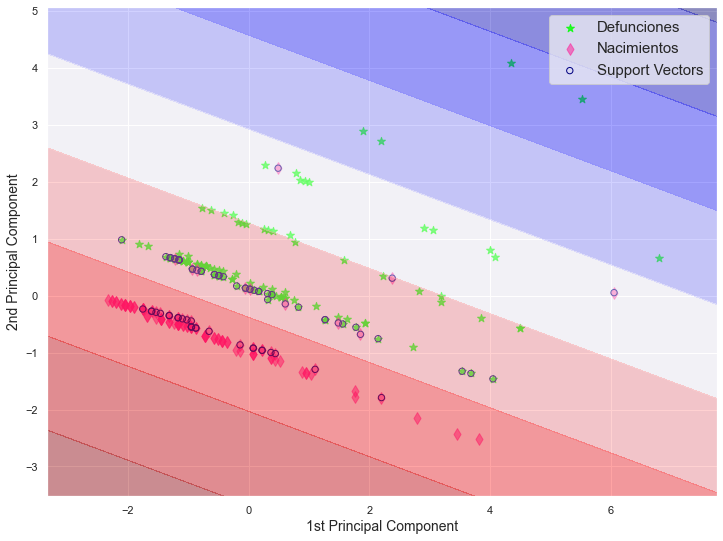

In [65]:
showGraph()

## Con variable cualitativas

### Cleaning data and encode labels

In [66]:
nc_qual_vars = response[0:3]
nc_qual_vars

['mom_scholarship', 'mom_dep_res', 'mom_occupation']

4 CATEGORIAS
* categoria1 alta movilidad
* categoria2 movilidad normal
* categoria3 poca movilidad
* categoria4 no especificado

In [67]:
data_joined = data_joined.replace("No especificado en otro grupo", "categoria4")
data_joined = data_joined.replace("NEOG", "categoria4")
data_joined = data_joined.replace("Ocupacion no bien especificada", "categoria4")
data_joined = data_joined.replace("Ocupación no bien especificada", "categoria4")

data_joined = data_joined.replace("Oficinistas", "categoria3")
data_joined = data_joined.replace("Operadores de instalaciones fijas y máquinas", "categoria3")
data_joined = data_joined.replace("Vendedores", "categoria3")
data_joined = data_joined.replace("Empleados contables y encargados del registro de materiales", "categoria3")
data_joined = data_joined.replace("Secretarios (general)", "categoria3")
data_joined = data_joined.replace("Trabajadores de los servicios personales", "categoria3")
data_joined = data_joined.replace("Empleados de contabilidad y cálculo de costos", "categoria3")

data_joined = data_joined.replace("Profesionales de la enseñanza", "categoria2")
data_joined = data_joined.replace("Estudiante", "categoria2")
data_joined = data_joined.replace("Maestros de enseñanza primaria", "categoria2")
data_joined = data_joined.replace("Demostradores de tiendas", "categoria2")
data_joined = data_joined.replace("Otro personal de apoyo administrativo", "categoria2")
data_joined = data_joined.replace("Operarios y oficiales de procesamiento de alimentos, de la confección, ebanistas, otros artesanos y afines", "categoria2")
data_joined = data_joined.replace("Trabajadores y asistentes sociales de nivel medio", "categoria2")
data_joined = data_joined.replace("Directores administradores y comerciales", "categoria2")
data_joined = data_joined.replace("Profesionales en derecho, en ciencias sociales y culturales", "categoria2")
data_joined = data_joined.replace("Profesionales de nivel medio de servicios jurídicos, sociales, culturales y afines", "categoria2")
data_joined = data_joined.replace("Profesionales de las ciencias y de la ingeniería", "categoria2")
data_joined = data_joined.replace("Trabajadores de los cuidados personales", "categoria2")


data_joined = data_joined.replace("Oficios domésticos no remunerados", "categoria1")
data_joined = data_joined.replace("Comerciantes de tiendas", "categoria1")
data_joined = data_joined.replace("Profesionales de nivel medio de la salud", "categoria1")
data_joined = data_joined.replace("Maestros preescolares", "categoria1")
data_joined = data_joined.replace("Profesionales de nivel medio de enfermería", "categoria1")
data_joined = data_joined.replace("Profesionales de la salud", "categoria1")
print()

In [68]:
# Se preparan los preprocesadores
categorical_preprocessor = LabelEncoder()
X_2 = data_joined[nc_qual_vars].apply(categorical_preprocessor.fit_transform)

### Entrenamiento y prueba

In [69]:
copied_data = data_joined.copy()
target = copied_data.pop("response")


quant_data = copied_data[nc_quan_vars]
quant_data =  pd.concat([quant_data, X_2], axis=1)


# 70% de entrenamiento y 30% prueba
X_train, X_test, y_train, y_test = train_test_split(quant_data, target,test_size=0.3,train_size=0.7, random_state=42)


In [70]:
scaler = StandardScaler()
scaler.fit(quant_data)
feature_scaled = scaler.transform(quant_data)


pca = PCA(n_components=4)
pca.fit(feature_scaled)
feature_scaled_pca = pca.transform(feature_scaled)

### Tuning

In [71]:
pipe_steps = [('scaler', StandardScaler()), ('pca', PCA()), ('SupVM', SVC())]

check_params= {
    'pca__n_components': [2], 
    'SupVM__C': [0.1, 0.5, 1], 
    'SupVM__gamma' : [0.01, 0.5, 1],
    'SupVM__kernel': ['rbf', 'linear', 'poly']
}

pipeline = Pipeline(pipe_steps)

grid = GridSearchCV(pipeline,check_params,refit=True,verbose=2)
grid.fit(X_train,y_train)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
[CV] END SupVM__C=0.1, SupVM__gamma=0.01, SupVM__kernel=rbf, pca__n_components=2; total time=   0.0s
[CV] END SupVM__C=0.1, SupVM__gamma=0.01, SupVM__kernel=rbf, pca__n_components=2; total time=   0.0s
[CV] END SupVM__C=0.1, SupVM__gamma=0.01, SupVM__kernel=rbf, pca__n_components=2; total time=   0.0s
[CV] END SupVM__C=0.1, SupVM__gamma=0.01, SupVM__kernel=rbf, pca__n_components=2; total time=   0.0s
[CV] END SupVM__C=0.1, SupVM__gamma=0.01, SupVM__kernel=rbf, pca__n_components=2; total time=   0.0s
[CV] END SupVM__C=0.1, SupVM__gamma=0.01, SupVM__kernel=linear, pca__n_components=2; total time=   0.0s
[CV] END SupVM__C=0.1, SupVM__gamma=0.01, SupVM__kernel=linear, pca__n_components=2; total time=   0.0s
[CV] END SupVM__C=0.1, SupVM__gamma=0.01, SupVM__kernel=linear, pca__n_components=2; total time=   0.0s
[CV] END SupVM__C=0.1, SupVM__gamma=0.01, SupVM__kernel=linear, pca__n_components=2; total time=   0.0s
[CV] END SupVM__C

In [ ]:
print ("grid best params: ", grid.best_params_) 

### Best result

In [ ]:
y_pred = grid.predict(X_test)
# print (Y_pred)
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix: \n")
print(cm)

In [ ]:
grid.score(X_test, y_test)

In [ ]:
# report performance
print ("Accuracy:", accuracy_score(y_test, y_pred))
print ("Precision:", precision_score(y_test, y_pred,average='weighted') )
print ("Recall: ", recall_score(y_test, y_pred,average='weighted'))

In [ ]:
cm = confusion_matrix(y_test,y_pred)
cm = list(cm)
labels = ['Defunciones', 'Nacimientos']

print('            '+labels[0]+'  '+labels[1])
print(labels[0], cm[0][0], '        ',cm[0][1])
print(labels[1], cm[1][0], '         ',cm[1][1])

In [ ]:
showGraph()